# Lab Four: Multi-Layer Perceptron
By Saaketh Koka, Vedant Nilabh, and Rayaan Irani 

In this lab, we will make a multi-layer perceptron (a type of Neural Network) which takes in data provided by the US Census Bearueau on a county-wide basis to determine the child poverty level in the county. 

## Load, Split, and Balance

In [28]:
#Import statements for the program 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [41]:
#Loads in all of the data into a Pandas Data Frame
df = pd.read_csv("acs2017_census_tract_data.csv")

df.dropna(inplace=True) #Removes rows that have missing values 

#This converts all of the string values into numerical values
le = preprocessing.LabelEncoder()
df['State'] = le.fit_transform(df['State'])
df['County'] = le.fit_transform(df['County'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  int64  
 2   County            72718 non-null  int64  
 3   TotalPop          72718 non-null  int64  
 4   Men               72718 non-null  int64  
 5   Women             72718 non-null  int64  
 6   Hispanic          72718 non-null  float64
 7   White             72718 non-null  float64
 8   Black             72718 non-null  float64
 9   Native            72718 non-null  float64
 10  Asian             72718 non-null  float64
 11  Pacific           72718 non-null  float64
 12  VotingAgeCitizen  72718 non-null  int64  
 13  Income            72718 non-null  float64
 14  IncomeErr         72718 non-null  float64
 15  IncomePerCap      72718 non-null  float64
 16  IncomePerCapErr   72718 non-null  float6

Median number of census tracts per county: 9.0
Mean number of census tracts per county: 37.21494370522006


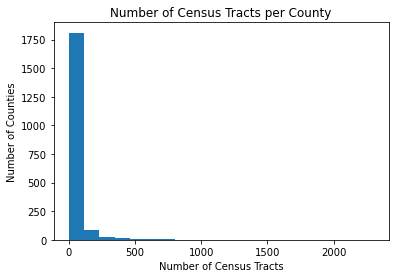

In [42]:
counts = list(df["County"].groupby(df["County"]).count())
plt.hist(counts, bins = 20)
plt.title("Number of Census Tracts per County")
plt.xlabel("Number of Census Tracts")
plt.ylabel("Number of Counties")

#Shows the median number of census tracts per county
print("Median number of census tracts per county: " + str(np.median(counts)))

#Shows the mean number of census tracts per county
print("Mean number of census tracts per county: " + str(np.mean(counts)))


Counites should be kept as a feature. This is becuase counties like states play a role in funding poverty relief programs. The extent to which these programs are funded is a result of the relative wealth of the county (as most county tax revenue is derived from property taxes). Due to this, it is possible that two census tracks that are very similar in other data types may differ greatly in poverty levels because one is surronded by a richer area and thus gets more county funding and the other does not. 

Text(0, 0.5, 'Number of Census Tracts')

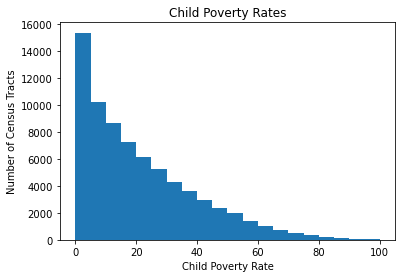

In [43]:
# Create histogram of child poverty rates
plt.hist(df["ChildPoverty"], bins = 20)
plt.title("Child Poverty Rates")
plt.xlabel("Child Poverty Rate")
plt.ylabel("Number of Census Tracts")


As can seen by the chart, the child poverty rates amongst census tracks do not follow a uniform or Gausian distribution. The data shows a mode near zero with the number of census tracks suffering a higher rates falling steadly from there. Due to the data being monomodal, there is no clear points to split the data into classes from Child Poverty Rates themselves. For this reason, we are spliting the data into classes each with an equal number of census tracks. This will allow us to use the full dataset for training and testing instead of having to throw away data to keep the classes balanced.

In [44]:
# Discreatizing the Unemployment Variable into 4 classes, 1,2,3,4
classes = pd.qcut(df['ChildPoverty'], 4, labels = [1,2,3,4])
df['ChildPoverty'] = classes


In [45]:
#Split the data into training and testing data. Each set should have roughly the same percentage of each child poverty class
X_train, X_test, Y_train, Y_test = train_test_split(df.drop('ChildPoverty', axis = 1), df['ChildPoverty'], test_size = 0.2, stratify = df['ChildPoverty'])

In [ ]:
#One hot encoding the Y_train and Y_test data
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)


## Pre-processing

In [34]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys
# accuracy score:
from sklearn.metrics import accuracy_score

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        # From the TLPMiniBatch class
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    # Cross Entropy Cost Function
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed when switching to cross entropy
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

## Modeling

## Exceptional Work